### Dataset and DataLoaders

In [8]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, data, transformations = None):

        self.im_paths = sorted(glob(f"{root}/{data}/images/*.png"))
        self.gt_paths = sorted(glob(f"{root}/{data}/mask/*.png"))
        self.transformations = transformations
        self.n_cls = 2
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, (gt > 105).unsqueeze(0).long()
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path, gt_path)

    def read_im(self, im_path, gt_path): return cv2.cvtColor(cv2.imread(im_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(gt_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.1], nws = 8):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    tr_ds = CustomSegmentationDataset(root = root, data = "Train", transformations = transformations)
    ts_ds = CustomSegmentationDataset(root = root, data = "Test", transformations = transformations)
    n_cls = tr_ds.n_cls
    
    tr_len = int(len(tr_ds) * split[0]); val_len = len(tr_ds) - tr_len
    
    # Data split
    tr_ds, val_ds = torch.utils.data.random_split(tr_ds, [tr_len, val_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(ts_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = nws)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = nws)
    test_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = nws)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([
    A.Resize(im_h, im_w),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask=True)
])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 32)


There are 63 number of images in the train set
There are 7 number of images in the validation set
There are 30 number of images in the test set



### Data Visualization

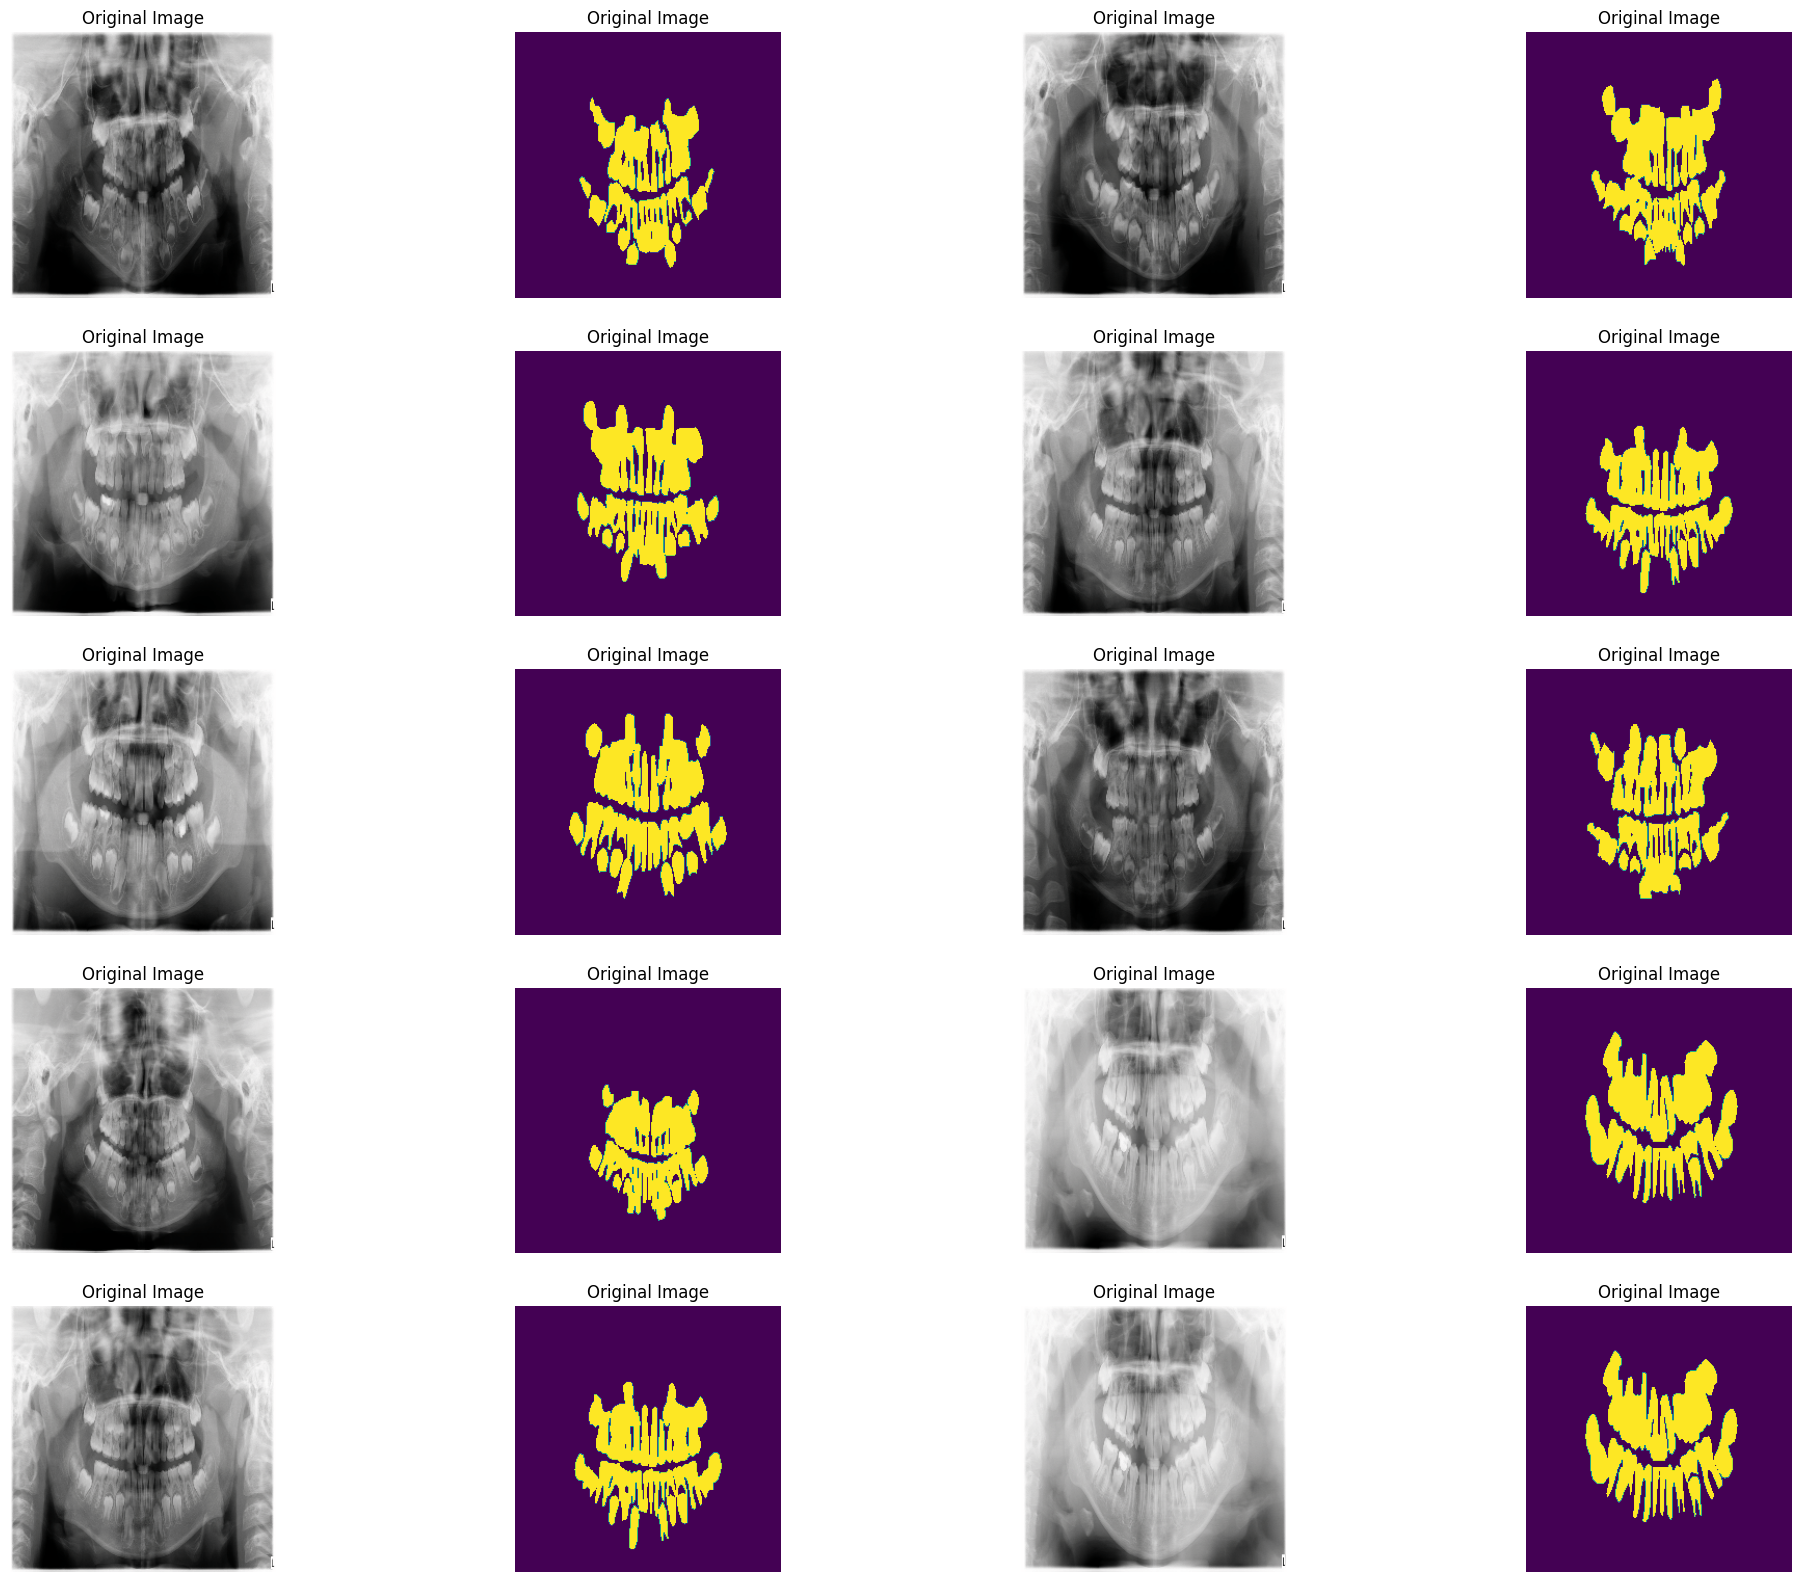

In [9]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)

### Train Process Setup

In [10]:
!pip install timm
from tqdm import tqdm
from torch.nn import functional as F
import timm
import torch.nn as nn
import os, time, numpy as np, torch

class FastViT_Segmentation(nn.Module):
    def __init__(self, backbone_name="fastvit_t8", num_classes=2):
        super().__init__()
        # Get FastViT backbone
        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=True)
        feat_channels = self.backbone.feature_info.channels()
        in_ch = feat_channels[-1]

        # Simple decoder head
        self.decoder = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        feats = self.backbone(x)   # list of feature maps
        x = feats[-1]              # take last stage
        out = self.decoder(x)
        out = torch.nn.functional.interpolate(out, size=(256,256), mode="bilinear", align_corners=False)
        return out

# Instantiate FastViT model
model = FastViT_Segmentation(backbone_name="fastvit_t8", num_classes=n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():
    def __init__(self, pred, gt, n_cls=2, eps=1e-7):
        # pred: raw logits from model [B,C,H,W]
        # gt: ground truth labels [B,H,W] or [B,1,H,W]
        self.pred = torch.argmax(pred, dim=1)
        self.gt = gt.squeeze(1) if gt.ndim == 4 else gt
        self.n_cls = n_cls
        self.eps = eps

    def _get_stats(self, cls):
        pred_c = (self.pred == cls)
        gt_c   = (self.gt == cls)
        tp = torch.logical_and(pred_c, gt_c).sum()
        fp = torch.logical_and(pred_c, ~gt_c).sum()
        fn = torch.logical_and(~pred_c, gt_c).sum()
        return tp, fp, fn

    def PA(self):
        total_correct = (self.pred == self.gt).sum()
        total = self.gt.numel()
        return float((total_correct / (total + self.eps)).detach().cpu().item())

    def mIoU(self):
        ious = []
        for c in range(self.n_cls):
            tp, fp, fn = self._get_stats(c)
            iou = tp / (tp + fp + fn + self.eps)
            ious.append(iou.detach().cpu().item())
        return float(np.nanmean(ious))

    def F1(self):
        f1s = []
        for c in range(self.n_cls):
            tp, fp, fn = self._get_stats(c)
            prec = tp / (tp + fp + self.eps)
            rec = tp / (tp + fn + self.eps)
            f1 = 2 * prec * rec / (prec + rec + self.eps)
            f1s.append(f1.detach().cpu().item())
        return float(np.nanmean(f1s))
    def loss(self):
        return self.loss_fn(self.logits, self.gt)

# ----------- Timer Helper --------
def tic_toc(start_time=None):
    return time.time() if start_time is None else time.time() - start_time

### Train and Validation of the Model

In [11]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs=30, 
          save_prefix="model", threshold=0.5, save_path="./", n_cls=2):

    model.to(device)
    history = {"train_loss": [], "val_loss": [],
               "train_PA": [], "val_PA": [],
               "train_mIoU": [], "val_mIoU": [],
               "train_F1": [], "val_F1": []}

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch} training started...")
        model.train()
        _tr_loss = _tr_pa = _tr_iou = _tr_f1 = 0.0

        for ims, gts in tqdm(tr_dl):
            ims, gts = ims.to(device), gts.to(device)
            preds = model(ims)

            # ----- loss -----
            loss = loss_fn(preds, gts.squeeze(1))

            # ----- backward -----
            opt.zero_grad()
            loss.backward()
            opt.step()

            # ----- metrics -----
            met = Metrics(preds, gts, n_cls=n_cls)
            _tr_loss += loss.item()
            _tr_pa   += met.PA()
            _tr_iou  += met.mIoU()
            _tr_f1   += met.F1()

        # Averages
        _tr_loss /= len(tr_dl)
        _tr_pa   /= len(tr_dl)
        _tr_iou  /= len(tr_dl)
        _tr_f1   /= len(tr_dl)

        history["train_loss"].append(_tr_loss)
        history["train_PA"].append(_tr_pa)
        history["train_mIoU"].append(_tr_iou)
        history["train_F1"].append(_tr_f1)

        # ---------- VALIDATION ----------
        model.eval()
        _val_loss = _val_pa = _val_iou = _val_f1 = 0.0
        with torch.no_grad():
            for ims, gts in val_dl:
                ims, gts = ims.to(device), gts.to(device)
                preds = model(ims)

                loss = loss_fn(preds, gts.squeeze(1))
                met = Metrics(preds, gts, n_cls=n_cls)

                _val_loss += loss.item()
                _val_pa   += met.PA()
                _val_iou  += met.mIoU()
                _val_f1   += met.F1()

        _val_loss /= len(val_dl)
        _val_pa   /= len(val_dl)
        _val_iou  /= len(val_dl)
        _val_f1   /= len(val_dl)

        history["val_loss"].append(_val_loss)
        history["val_PA"].append(_val_pa)
        history["val_mIoU"].append(_val_iou)
        history["val_F1"].append(_val_f1)

        print(f"Epoch {epoch} | "
              f"Train Loss: {_tr_loss:.4f}, Val Loss: {_val_loss:.4f}, "
              f"Train PA: {_tr_pa:.4f}, Val PA: {_val_pa:.4f}, "
              f"Train mIoU: {_tr_iou:.4f}, Val mIoU: {_val_iou:.4f}, "
              f"Train F1: {_tr_f1:.4f}, Val F1: {_val_f1:.4f}")

        # ----- Save model -----
        torch.save(model.state_dict(), f"{save_path}/{save_prefix}_epoch{epoch}.pth")

    return history

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(
    model=model,
    tr_dl=tr_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    opt=optimizer,
    device=device,
    epochs=100,
    save_prefix="dental",
    n_cls=n_cls
)

Epoch 1 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 1 | Train Loss: 0.6747, Val Loss: 0.6746, Train PA: 0.8415, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 2 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 2 | Train Loss: 0.6720, Val Loss: 0.6723, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 3 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 3 | Train Loss: 0.6666, Val Loss: 0.6695, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 4 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 4 | Train Loss: 0.6558, Val Loss: 0.6651, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 5 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 5 | Train Loss: 0.6342, Val Loss: 0.6566, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 6 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 6 | Train Loss: 0.5952, Val Loss: 0.6387, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 7 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 7 | Train Loss: 0.5311, Val Loss: 0.6075, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 8 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 8 | Train Loss: 0.4445, Val Loss: 0.5575, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 9 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 9 | Train Loss: 0.3510, Val Loss: 0.4907, Train PA: 0.8418, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 10 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 10 | Train Loss: 0.2854, Val Loss: 0.4293, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 11 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 11 | Train Loss: 0.2590, Val Loss: 0.3918, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 12 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 12 | Train Loss: 0.2432, Val Loss: 0.3747, Train PA: 0.8418, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 13 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 13 | Train Loss: 0.2329, Val Loss: 0.3459, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 14 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 14 | Train Loss: 0.2271, Val Loss: 0.3120, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 15 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 15 | Train Loss: 0.2236, Val Loss: 0.3052, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 16 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 16 | Train Loss: 0.2196, Val Loss: 0.2768, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 17 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 17 | Train Loss: 0.2155, Val Loss: 0.2521, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 18 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 18 | Train Loss: 0.2121, Val Loss: 0.2420, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 19 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 19 | Train Loss: 0.2111, Val Loss: 0.2368, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 20 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 20 | Train Loss: 0.2089, Val Loss: 0.2358, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 21 training started...


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Epoch 21 | Train Loss: 0.2071, Val Loss: 0.2338, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 22 training started...


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Epoch 22 | Train Loss: 0.2056, Val Loss: 0.2332, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 23 training started...


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch 23 | Train Loss: 0.2041, Val Loss: 0.2312, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 24 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 24 | Train Loss: 0.2037, Val Loss: 0.2305, Train PA: 0.8415, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 25 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 25 | Train Loss: 0.2015, Val Loss: 0.2299, Train PA: 0.8416, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 26 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 26 | Train Loss: 0.2008, Val Loss: 0.2259, Train PA: 0.8415, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 27 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 27 | Train Loss: 0.1986, Val Loss: 0.2224, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 28 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 28 | Train Loss: 0.1975, Val Loss: 0.2204, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 29 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 29 | Train Loss: 0.1983, Val Loss: 0.2203, Train PA: 0.8418, Val PA: 0.8215, Train mIoU: 0.4209, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4510
Epoch 30 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 30 | Train Loss: 0.1948, Val Loss: 0.2205, Train PA: 0.8417, Val PA: 0.8215, Train mIoU: 0.4208, Val mIoU: 0.4108, Train F1: 0.4570, Val F1: 0.4511
Epoch 31 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 31 | Train Loss: 0.1935, Val Loss: 0.2178, Train PA: 0.8417, Val PA: 0.8217, Train mIoU: 0.4211, Val mIoU: 0.4115, Train F1: 0.4575, Val F1: 0.4524
Epoch 32 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 32 | Train Loss: 0.1917, Val Loss: 0.2160, Train PA: 0.8421, Val PA: 0.8233, Train mIoU: 0.4235, Val mIoU: 0.4191, Train F1: 0.4621, Val F1: 0.4666
Epoch 33 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 33 | Train Loss: 0.1905, Val Loss: 0.2156, Train PA: 0.8446, Val PA: 0.8353, Train mIoU: 0.4385, Val mIoU: 0.4733, Train F1: 0.4895, Val F1: 0.5571
Epoch 34 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 34 | Train Loss: 0.1884, Val Loss: 0.2131, Train PA: 0.8582, Val PA: 0.8657, Train mIoU: 0.5047, Val mIoU: 0.5928, Train F1: 0.5932, Val F1: 0.7090
Epoch 35 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 35 | Train Loss: 0.1865, Val Loss: 0.2104, Train PA: 0.8836, Val PA: 0.8900, Train mIoU: 0.6152, Val mIoU: 0.6801, Train F1: 0.7279, Val F1: 0.7929
Epoch 36 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 36 | Train Loss: 0.1840, Val Loss: 0.2084, Train PA: 0.9050, Val PA: 0.9029, Train mIoU: 0.7002, Val mIoU: 0.7245, Train F1: 0.8079, Val F1: 0.8295
Epoch 37 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 37 | Train Loss: 0.1809, Val Loss: 0.2046, Train PA: 0.9164, Val PA: 0.9090, Train mIoU: 0.7439, Val mIoU: 0.7465, Train F1: 0.8432, Val F1: 0.8465
Epoch 38 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 38 | Train Loss: 0.1775, Val Loss: 0.1999, Train PA: 0.9217, Val PA: 0.9113, Train mIoU: 0.7639, Val mIoU: 0.7568, Train F1: 0.8582, Val F1: 0.8543
Epoch 39 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 39 | Train Loss: 0.1758, Val Loss: 0.1971, Train PA: 0.9225, Val PA: 0.9113, Train mIoU: 0.7684, Val mIoU: 0.7599, Train F1: 0.8616, Val F1: 0.8567
Epoch 40 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 40 | Train Loss: 0.1698, Val Loss: 0.1923, Train PA: 0.9235, Val PA: 0.9113, Train mIoU: 0.7758, Val mIoU: 0.7634, Train F1: 0.8671, Val F1: 0.8594
Epoch 41 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 41 | Train Loss: 0.1648, Val Loss: 0.1933, Train PA: 0.9251, Val PA: 0.9129, Train mIoU: 0.7816, Val mIoU: 0.7656, Train F1: 0.8713, Val F1: 0.8609
Epoch 42 training started...


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 42 | Train Loss: 0.1608, Val Loss: 0.1926, Train PA: 0.9256, Val PA: 0.9142, Train mIoU: 0.7830, Val mIoU: 0.7674, Train F1: 0.8723, Val F1: 0.8621
Epoch 43 training started...


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 43 | Train Loss: 0.1592, Val Loss: 0.1908, Train PA: 0.9253, Val PA: 0.9151, Train mIoU: 0.7833, Val mIoU: 0.7706, Train F1: 0.8725, Val F1: 0.8644
Epoch 44 training started...


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 44 | Train Loss: 0.1578, Val Loss: 0.1906, Train PA: 0.9263, Val PA: 0.9156, Train mIoU: 0.7865, Val mIoU: 0.7712, Train F1: 0.8747, Val F1: 0.8647
Epoch 45 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 45 | Train Loss: 0.1558, Val Loss: 0.2003, Train PA: 0.9271, Val PA: 0.9133, Train mIoU: 0.7870, Val mIoU: 0.7592, Train F1: 0.8750, Val F1: 0.8559
Epoch 46 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 46 | Train Loss: 0.1541, Val Loss: 0.2027, Train PA: 0.9279, Val PA: 0.9117, Train mIoU: 0.7885, Val mIoU: 0.7533, Train F1: 0.8760, Val F1: 0.8515
Epoch 47 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 47 | Train Loss: 0.1522, Val Loss: 0.2045, Train PA: 0.9284, Val PA: 0.9121, Train mIoU: 0.7892, Val mIoU: 0.7534, Train F1: 0.8764, Val F1: 0.8515
Epoch 48 training started...


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 48 | Train Loss: 0.1514, Val Loss: 0.2026, Train PA: 0.9291, Val PA: 0.9132, Train mIoU: 0.7904, Val mIoU: 0.7572, Train F1: 0.8773, Val F1: 0.8543
Epoch 49 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 49 | Train Loss: 0.1503, Val Loss: 0.2101, Train PA: 0.9294, Val PA: 0.9119, Train mIoU: 0.7935, Val mIoU: 0.7510, Train F1: 0.8795, Val F1: 0.8497
Epoch 50 training started...


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch 50 | Train Loss: 0.1495, Val Loss: 0.2150, Train PA: 0.9300, Val PA: 0.9115, Train mIoU: 0.7925, Val mIoU: 0.7496, Train F1: 0.8787, Val F1: 0.8486
Epoch 51 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 51 | Train Loss: 0.1480, Val Loss: 0.1939, Train PA: 0.9306, Val PA: 0.9166, Train mIoU: 0.7943, Val mIoU: 0.7671, Train F1: 0.8799, Val F1: 0.8615
Epoch 52 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 52 | Train Loss: 0.1477, Val Loss: 0.2011, Train PA: 0.9306, Val PA: 0.9152, Train mIoU: 0.7960, Val mIoU: 0.7620, Train F1: 0.8812, Val F1: 0.8578
Epoch 53 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 53 | Train Loss: 0.1456, Val Loss: 0.1988, Train PA: 0.9315, Val PA: 0.9143, Train mIoU: 0.7965, Val mIoU: 0.7597, Train F1: 0.8814, Val F1: 0.8561
Epoch 54 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 54 | Train Loss: 0.1447, Val Loss: 0.1938, Train PA: 0.9325, Val PA: 0.9159, Train mIoU: 0.7994, Val mIoU: 0.7651, Train F1: 0.8833, Val F1: 0.8600
Epoch 55 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 55 | Train Loss: 0.1438, Val Loss: 0.1880, Train PA: 0.9326, Val PA: 0.9183, Train mIoU: 0.7997, Val mIoU: 0.7737, Train F1: 0.8836, Val F1: 0.8663
Epoch 56 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 56 | Train Loss: 0.1428, Val Loss: 0.1911, Train PA: 0.9332, Val PA: 0.9167, Train mIoU: 0.8014, Val mIoU: 0.7694, Train F1: 0.8847, Val F1: 0.8632
Epoch 57 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 57 | Train Loss: 0.1423, Val Loss: 0.2010, Train PA: 0.9337, Val PA: 0.9158, Train mIoU: 0.8015, Val mIoU: 0.7629, Train F1: 0.8848, Val F1: 0.8584
Epoch 58 training started...


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch 58 | Train Loss: 0.1412, Val Loss: 0.2003, Train PA: 0.9339, Val PA: 0.9154, Train mIoU: 0.8029, Val mIoU: 0.7620, Train F1: 0.8857, Val F1: 0.8577
Epoch 59 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 59 | Train Loss: 0.1407, Val Loss: 0.2000, Train PA: 0.9344, Val PA: 0.9157, Train mIoU: 0.8041, Val mIoU: 0.7625, Train F1: 0.8865, Val F1: 0.8581
Epoch 60 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 60 | Train Loss: 0.1399, Val Loss: 0.1880, Train PA: 0.9349, Val PA: 0.9176, Train mIoU: 0.8050, Val mIoU: 0.7699, Train F1: 0.8871, Val F1: 0.8635
Epoch 61 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 61 | Train Loss: 0.1388, Val Loss: 0.1969, Train PA: 0.9355, Val PA: 0.9161, Train mIoU: 0.8068, Val mIoU: 0.7628, Train F1: 0.8884, Val F1: 0.8582
Epoch 62 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 62 | Train Loss: 0.1386, Val Loss: 0.1945, Train PA: 0.9359, Val PA: 0.9166, Train mIoU: 0.8066, Val mIoU: 0.7651, Train F1: 0.8881, Val F1: 0.8600
Epoch 63 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 63 | Train Loss: 0.1380, Val Loss: 0.2028, Train PA: 0.9362, Val PA: 0.9167, Train mIoU: 0.8089, Val mIoU: 0.7639, Train F1: 0.8898, Val F1: 0.8590
Epoch 64 training started...


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 64 | Train Loss: 0.1381, Val Loss: 0.2010, Train PA: 0.9363, Val PA: 0.9151, Train mIoU: 0.8084, Val mIoU: 0.7597, Train F1: 0.8893, Val F1: 0.8560
Epoch 65 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 65 | Train Loss: 0.1363, Val Loss: 0.2018, Train PA: 0.9373, Val PA: 0.9165, Train mIoU: 0.8107, Val mIoU: 0.7625, Train F1: 0.8909, Val F1: 0.8579
Epoch 66 training started...


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch 66 | Train Loss: 0.1359, Val Loss: 0.1920, Train PA: 0.9373, Val PA: 0.9168, Train mIoU: 0.8095, Val mIoU: 0.7667, Train F1: 0.8900, Val F1: 0.8612
Epoch 67 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 67 | Train Loss: 0.1353, Val Loss: 0.1964, Train PA: 0.9380, Val PA: 0.9180, Train mIoU: 0.8138, Val mIoU: 0.7680, Train F1: 0.8930, Val F1: 0.8620
Epoch 68 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 68 | Train Loss: 0.1349, Val Loss: 0.1950, Train PA: 0.9378, Val PA: 0.9183, Train mIoU: 0.8113, Val mIoU: 0.7703, Train F1: 0.8912, Val F1: 0.8637
Epoch 69 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 69 | Train Loss: 0.1342, Val Loss: 0.1976, Train PA: 0.9386, Val PA: 0.9193, Train mIoU: 0.8149, Val mIoU: 0.7720, Train F1: 0.8937, Val F1: 0.8648
Epoch 70 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 70 | Train Loss: 0.1339, Val Loss: 0.1954, Train PA: 0.9388, Val PA: 0.9201, Train mIoU: 0.8131, Val mIoU: 0.7772, Train F1: 0.8924, Val F1: 0.8686
Epoch 71 training started...


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 71 | Train Loss: 0.1332, Val Loss: 0.1916, Train PA: 0.9393, Val PA: 0.9212, Train mIoU: 0.8170, Val mIoU: 0.7790, Train F1: 0.8951, Val F1: 0.8699
Epoch 72 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 72 | Train Loss: 0.1330, Val Loss: 0.1875, Train PA: 0.9394, Val PA: 0.9219, Train mIoU: 0.8147, Val mIoU: 0.7810, Train F1: 0.8934, Val F1: 0.8713
Epoch 73 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 73 | Train Loss: 0.1320, Val Loss: 0.1868, Train PA: 0.9399, Val PA: 0.9226, Train mIoU: 0.8180, Val mIoU: 0.7842, Train F1: 0.8957, Val F1: 0.8736
Epoch 74 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 74 | Train Loss: 0.1313, Val Loss: 0.1858, Train PA: 0.9404, Val PA: 0.9224, Train mIoU: 0.8183, Val mIoU: 0.7827, Train F1: 0.8959, Val F1: 0.8725
Epoch 75 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 75 | Train Loss: 0.1314, Val Loss: 0.1819, Train PA: 0.9403, Val PA: 0.9224, Train mIoU: 0.8186, Val mIoU: 0.7844, Train F1: 0.8961, Val F1: 0.8737
Epoch 76 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 76 | Train Loss: 0.1298, Val Loss: 0.1886, Train PA: 0.9412, Val PA: 0.9211, Train mIoU: 0.8200, Val mIoU: 0.7775, Train F1: 0.8970, Val F1: 0.8687
Epoch 77 training started...


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 77 | Train Loss: 0.1298, Val Loss: 0.1833, Train PA: 0.9413, Val PA: 0.9227, Train mIoU: 0.8197, Val mIoU: 0.7845, Train F1: 0.8968, Val F1: 0.8737
Epoch 78 training started...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch 78 | Train Loss: 0.1290, Val Loss: 0.1862, Train PA: 0.9416, Val PA: 0.9224, Train mIoU: 0.8216, Val mIoU: 0.7831, Train F1: 0.8980, Val F1: 0.8727
Epoch 79 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 79 | Train Loss: 0.1280, Val Loss: 0.1931, Train PA: 0.9423, Val PA: 0.9225, Train mIoU: 0.8237, Val mIoU: 0.7807, Train F1: 0.8994, Val F1: 0.8710
Epoch 80 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 80 | Train Loss: 0.1273, Val Loss: 0.1878, Train PA: 0.9426, Val PA: 0.9232, Train mIoU: 0.8233, Val mIoU: 0.7833, Train F1: 0.8991, Val F1: 0.8728
Epoch 81 training started...


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 81 | Train Loss: 0.1264, Val Loss: 0.2019, Train PA: 0.9433, Val PA: 0.9201, Train mIoU: 0.8259, Val mIoU: 0.7714, Train F1: 0.9008, Val F1: 0.8643
Epoch 82 training started...


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch 82 | Train Loss: 0.1265, Val Loss: 0.1905, Train PA: 0.9431, Val PA: 0.9222, Train mIoU: 0.8239, Val mIoU: 0.7807, Train F1: 0.8995, Val F1: 0.8710
Epoch 83 training started...


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 83 | Train Loss: 0.1256, Val Loss: 0.1923, Train PA: 0.9435, Val PA: 0.9225, Train mIoU: 0.8275, Val mIoU: 0.7805, Train F1: 0.9019, Val F1: 0.8708
Epoch 84 training started...


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch 84 | Train Loss: 0.1253, Val Loss: 0.2025, Train PA: 0.9436, Val PA: 0.9185, Train mIoU: 0.8259, Val mIoU: 0.7674, Train F1: 0.9008, Val F1: 0.8614
Epoch 85 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 85 | Train Loss: 0.1247, Val Loss: 0.1962, Train PA: 0.9441, Val PA: 0.9221, Train mIoU: 0.8271, Val mIoU: 0.7786, Train F1: 0.9016, Val F1: 0.8694
Epoch 86 training started...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch 86 | Train Loss: 0.1242, Val Loss: 0.1887, Train PA: 0.9442, Val PA: 0.9223, Train mIoU: 0.8282, Val mIoU: 0.7819, Train F1: 0.9023, Val F1: 0.8718
Epoch 87 training started...


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch 87 | Train Loss: 0.1237, Val Loss: 0.2048, Train PA: 0.9445, Val PA: 0.9201, Train mIoU: 0.8300, Val mIoU: 0.7715, Train F1: 0.9035, Val F1: 0.8643
Epoch 88 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 88 | Train Loss: 0.1234, Val Loss: 0.1847, Train PA: 0.9445, Val PA: 0.9232, Train mIoU: 0.8276, Val mIoU: 0.7849, Train F1: 0.9019, Val F1: 0.8740
Epoch 89 training started...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 89 | Train Loss: 0.1229, Val Loss: 0.1959, Train PA: 0.9451, Val PA: 0.9222, Train mIoU: 0.8308, Val mIoU: 0.7791, Train F1: 0.9040, Val F1: 0.8698
Epoch 90 training started...


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 90 | Train Loss: 0.1222, Val Loss: 0.1937, Train PA: 0.9452, Val PA: 0.9227, Train mIoU: 0.8303, Val mIoU: 0.7811, Train F1: 0.9036, Val F1: 0.8712
Epoch 91 training started...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 91 | Train Loss: 0.1225, Val Loss: 0.1965, Train PA: 0.9451, Val PA: 0.9221, Train mIoU: 0.8298, Val mIoU: 0.7791, Train F1: 0.9033, Val F1: 0.8698
Epoch 92 training started...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch 92 | Train Loss: 0.1223, Val Loss: 0.1914, Train PA: 0.9453, Val PA: 0.9235, Train mIoU: 0.8319, Val mIoU: 0.7822, Train F1: 0.9047, Val F1: 0.8720
Epoch 93 training started...


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Epoch 93 | Train Loss: 0.1214, Val Loss: 0.1941, Train PA: 0.9455, Val PA: 0.9231, Train mIoU: 0.8303, Val mIoU: 0.7815, Train F1: 0.9036, Val F1: 0.8715
Epoch 94 training started...


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch 94 | Train Loss: 0.1215, Val Loss: 0.1920, Train PA: 0.9456, Val PA: 0.9246, Train mIoU: 0.8324, Val mIoU: 0.7867, Train F1: 0.9050, Val F1: 0.8751
Epoch 95 training started...


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch 95 | Train Loss: 0.1213, Val Loss: 0.1884, Train PA: 0.9456, Val PA: 0.9241, Train mIoU: 0.8305, Val mIoU: 0.7882, Train F1: 0.9037, Val F1: 0.8763
Epoch 96 training started...


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch 96 | Train Loss: 0.1210, Val Loss: 0.1958, Train PA: 0.9458, Val PA: 0.9240, Train mIoU: 0.8337, Val mIoU: 0.7840, Train F1: 0.9059, Val F1: 0.8732
Epoch 97 training started...


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch 97 | Train Loss: 0.1201, Val Loss: 0.1870, Train PA: 0.9462, Val PA: 0.9253, Train mIoU: 0.8316, Val mIoU: 0.7915, Train F1: 0.9044, Val F1: 0.8785
Epoch 98 training started...


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch 98 | Train Loss: 0.1201, Val Loss: 0.1887, Train PA: 0.9463, Val PA: 0.9252, Train mIoU: 0.8353, Val mIoU: 0.7890, Train F1: 0.9069, Val F1: 0.8767
Epoch 99 training started...


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 99 | Train Loss: 0.1193, Val Loss: 0.1903, Train PA: 0.9464, Val PA: 0.9247, Train mIoU: 0.8322, Val mIoU: 0.7879, Train F1: 0.9048, Val F1: 0.8760
Epoch 100 training started...


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 100 | Train Loss: 0.1196, Val Loss: 0.1803, Train PA: 0.9466, Val PA: 0.9250, Train mIoU: 0.8349, Val mIoU: 0.7925, Train F1: 0.9066, Val F1: 0.8794


### Learning Curves

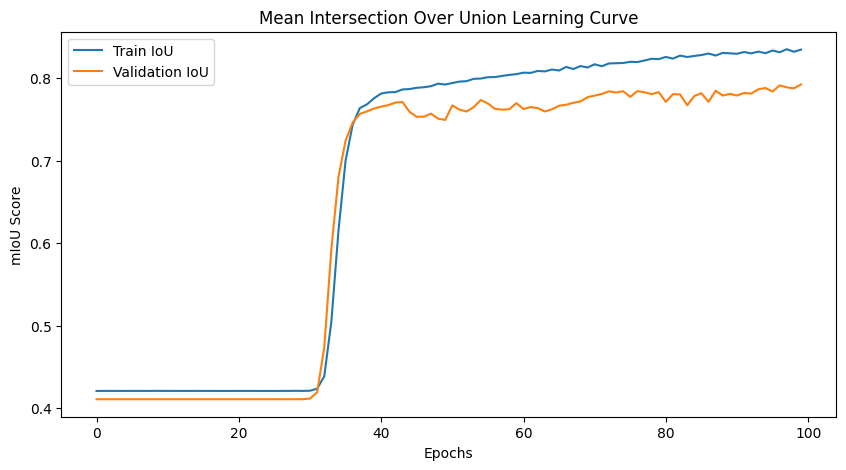

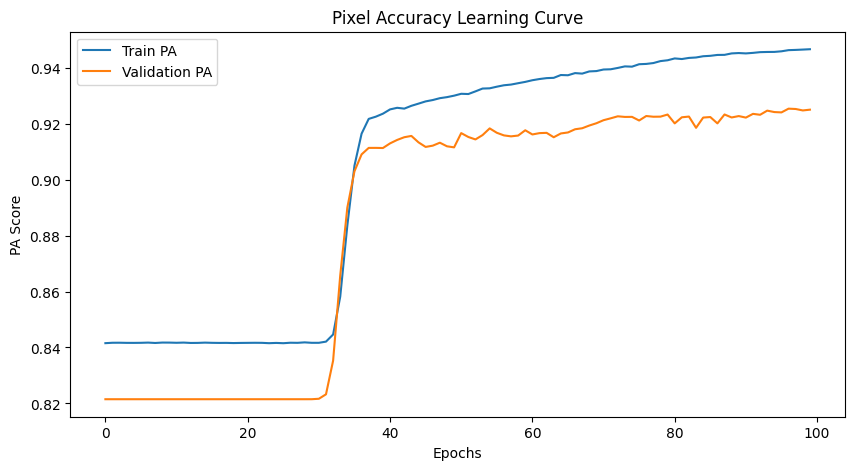

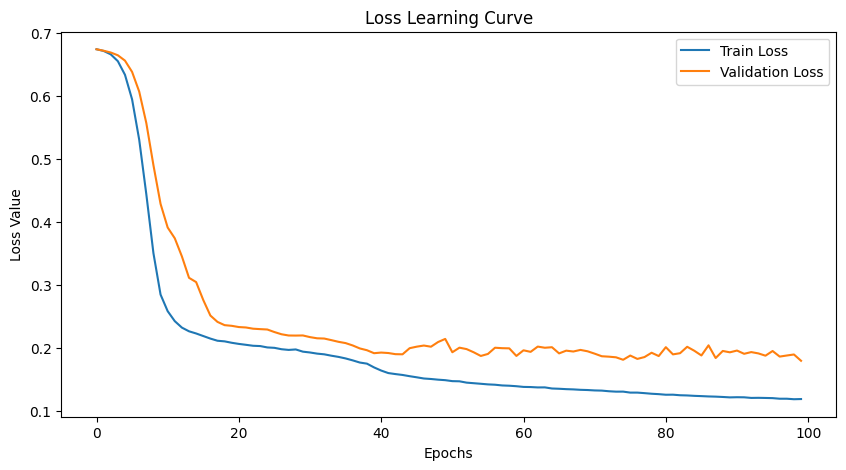

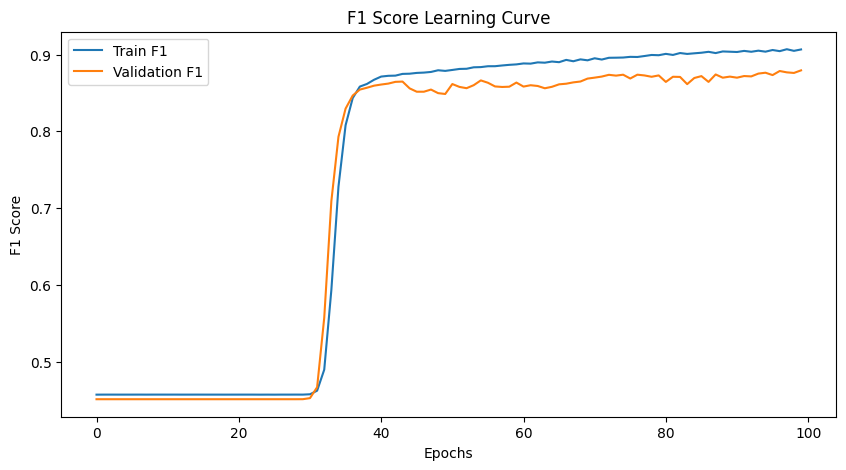

In [13]:
import matplotlib.pyplot as plt

class Plot:
    def __init__(self, res):
        self.res = res
        
        self.visualize(metric1="train_mIoU", metric2="val_mIoU",
                       label1="Train IoU", label2="Validation IoU",
                       title="Mean Intersection Over Union Learning Curve",
                       ylabel="mIoU Score")
        
        self.visualize(metric1="train_PA", metric2="val_PA",
                       label1="Train PA", label2="Validation PA",
                       title="Pixel Accuracy Learning Curve",
                       ylabel="PA Score")
        
        self.visualize(metric1="train_loss", metric2="val_loss",
                       label1="Train Loss", label2="Validation Loss",
                       title="Loss Learning Curve",
                       ylabel="Loss Value")
        
        self.visualize(metric1="train_F1", metric2="val_F1",
                       label1="Train F1", label2="Validation F1",
                       title="F1 Score Learning Curve",
                       ylabel="F1 Score")
    
    def plot(self, metric, label):
        plt.plot(self.res[metric], label=label)
    
    def decorate(self, ylabel, title):
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        plt.figure(figsize=(10,5))
        self.plot(metric1, label1)
        self.plot(metric2, label2)
        self.decorate(ylabel, title)
             
        
Plot(history)